In [279]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC


In [255]:
data = pd.read_table('https://raw.githubusercontent.com/krishnaik06/DNA-Sequencing-Classifier/master/chimp_data.txt')

In [256]:
data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [257]:
data.shape

(1682, 2)

# Feature Engineering

In [258]:
#checking null value
data.isnull().sum()

sequence    0
class       0
dtype: int64

In [259]:
#some information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
sequence    1682 non-null object
class       1682 non-null int64
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [260]:
#printing unique value of class column
data['class'].unique()

array([4, 6, 0, 1, 3, 2, 5])

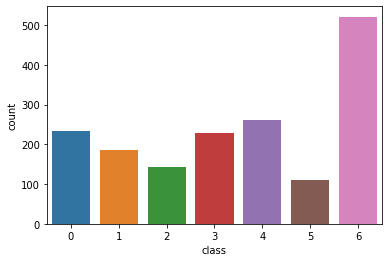

In [261]:
#checking is it balance or imbalance dataset
sns.countplot(data['class'])

We can say the dataset is balance

In [262]:
#using k-mers technique to divide DNA sequence
def get_k_mers(sequence, size=8):
    return [sequence[x:x+size].lower() for x in range(len(sequence)-size+1)]

data['word'] = data.apply(lambda x: get_k_mers(x['sequence']), axis=1)

In [263]:
data

,sequence,class,word
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4,"[atgcccca, tgccccaa, gccccaac, ccccaact, cccaa..."
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4,"[atgaacga, tgaacgaa, gaacgaaa, aacgaaaa, acgaa..."
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4,"[atggcctc, tggcctcg, ggcctcgc, gcctcgcg, cctcg..."
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4,"[atggcctc, tggcctcg, ggcctcgc, gcctcgcg, cctcg..."
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6,"[atgggcag, tgggcagc, gggcagcg, ggcagcgc, gcagc..."
...,...,...,...
1677,ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...,5,"[atgctgag, tgctgagc, gctgagcg, ctgagcgg, tgagc..."
1678,ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...,5,"[atgctgag, tgctgagc, gctgagcg, ctgagcgg, tgagc..."
1679,ATGAAGCGACCCAAGGAGCCGAGCGGCTCCGACGGGGAGTCCGACG...,6,"[atgaagcg, tgaagcga, gaagcgac, aagcgacc, agcga..."
1680,ATGACTGGAACCCCAAAGACTCAAGAAGGAGCTAAAGATCTTGAAG...,3,"[atgactgg, tgactgga, gactggaa, actggaac, ctgga..."


In [264]:
#we need to drop the sequence column
data.drop('sequence', axis=1, inplace=True)
data.head()

,class,word
0,4,"[atgcccca, tgccccaa, gccccaac, ccccaact, cccaa..."
1,4,"[atgaacga, tgaacgaa, gaacgaaa, aacgaaaa, acgaa..."
2,4,"[atggcctc, tggcctcg, ggcctcgc, gcctcgcg, cctcg..."
3,4,"[atggcctc, tggcctcg, ggcctcgc, gcctcgcg, cctcg..."
4,6,"[atgggcag, tgggcagc, gggcagcg, ggcagcgc, gcagc..."


In [265]:
#Label data
y = data['class']

In [266]:
#converting every DNA sequence to paragraph
X = list(data['word'])
for row in range(len(X)):
    X[row] = ' '.join(X[row])

In [267]:
#printing only one DNA sequence
X[0]

'atgcccca tgccccaa gccccaac ccccaact cccaacta ccaactaa caactaaa aactaaat actaaata ctaaatac taaatacc aaataccg aataccgc ataccgcc taccgccg accgccgt ccgccgta cgccgtat gccgtatg ccgtatga cgtatgac gtatgacc tatgaccc atgaccca tgacccac gacccacc acccacca cccaccat ccaccata caccataa accataat ccataatt cataatta ataattac taattacc aattaccc attacccc ttaccccc taccccca acccccat cccccata ccccatac cccatact ccatactc catactcc atactcct tactcctg actcctga ctcctgac tcctgaca cctgacac ctgacact tgacacta gacactat acactatt cactattt actatttc ctatttct tatttctc atttctcg tttctcgt ttctcgtc tctcgtca ctcgtcac tcgtcacc cgtcaccc gtcaccca tcacccaa cacccaac acccaact cccaacta ccaactaa caactaaa aactaaaa actaaaaa ctaaaaat taaaaata aaaaatat aaaatatt aaatatta aatattaa atattaaa tattaaat attaaatt ttaaattc taaattca aaattcaa aattcaaa attcaaat ttcaaatt tcaaatta caaattac aaattacc aattacca attaccat ttaccatc taccatct accatcta ccatctac catctacc atctaccc tctacccc ctaccccc tacccccc acccccct cccccctc ccccctca cccctcac ccctcacc cctcacca ctcaccaa 

In [268]:
#applying BAG of WORDS using TfidfVectorizer to convert the paragraph to vector 
tv = TfidfVectorizer(ngram_range=(5,5))
tv.fit(X)
X = tv.transform(X)


In [269]:
print('Shape of X after converting to vector :',X.shape)
print('Shape of y :',y.shape)

Shape of X after converting to vector : (1682, 1215014)
Shape of y : (1682,)


In [270]:
#dividing dataset in train and test
xtrain,xtest, ytrain,ytest = train_test_split(X,y, test_size=.25, random_state=0)
print('Shape of xtrain :',xtrain.shape)
print('Shape of xtest :',xtest.shape)
print('Shape of ytrain :',ytrain.shape)
print('Shape of ytest :',ytest.shape)

Shape of xtrain : (1261, 1215014)
Shape of xtest : (421, 1215014)
Shape of ytrain : (1261,)
Shape of ytest : (421,)


# model

In [282]:
model = MultinomialNB()
model.fit(xtrain,ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [283]:
model.score(xtest,ytest)

0.8004750593824228

In [284]:
predicted = model.predict(xtest)

In [285]:
#classification report
print(classification_report(ytest,predicted))

              precision    recall  f1-score   support

           0       1.00      0.63      0.77        54
           1       1.00      0.88      0.94        42
           2       1.00      0.88      0.93        32
           3       1.00      0.77      0.87        66
           4       1.00      0.67      0.80        64
           5       1.00      0.39      0.56        31
           6       0.61      1.00      0.76       132

    accuracy                           0.80       421
   macro avg       0.94      0.75      0.81       421
weighted avg       0.88      0.80      0.80       421



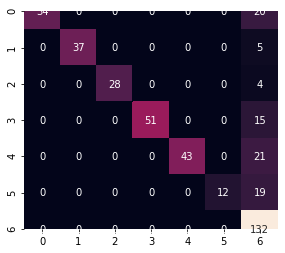

In [286]:
#confusion matrix
sns.heatmap(confusion_matrix(ytest,predicted), square=True, annot=True, fmt='d', cbar=False)